## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

In [ ]:
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 128
IMG_SIZE = 32 
C_IN = 1 # Number of input channels
LR = 2e-5
EPOCHS = 100

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

100%|██████████| 26421880/26421880 [00:02<00:00, 11605880.59it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 215739.68it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3930788.99it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22873174.78it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



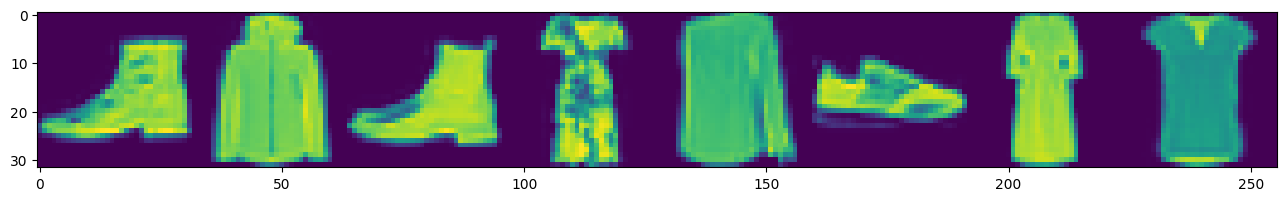

In [ ]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## VAE 

VAE is a generative model consisting of an encoder network and a decoder network. The encoder maps the input data into a latent space, where the data is represented by probability distributions. A decoder network generates the output data from samples of the latent space.

VAE is trained using a variational inference approach, where the goal is to maximize the evidence lower bound (ELBO) of the log-likelihood of the data. The ELBO consists of two terms: the reconstruction loss, which measures how well the decoder can reconstruct the input data from the latent space, and the KL divergence between the prior (considered Gaussian) and posterior distributions over the latent space. The posterior distribution is usually considered Gaussian, and the encoder only tries to learn its mean and variance. Given the mean and the variance, one can use the reparameterization trick to sample from the encoder.

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VariationalEncoder, self).__init__()


        self.dims = args
        self.options = kwargs

        self.conv1 = nn.Conv2d(1,4,3,padding=1)
        self.conv2 = nn.Conv2d(4,8,3,stride=2)
        self.batch2 = nn.BatchNorm2d(8)
        self.conv3   = nn.Conv2d(8,16,4, stride=2)

        self.fc1   = nn.Linear(16*6*6,self.dims[0])
        self.fc2   = nn.Linear(self.dims[0],self.dims[1])
        self.fc3   = nn.Linear(self.dims[0], self.dims[1])

        self.dropout_value = self.options.get('dropout', None)
        self.batch_norm = self.options.get('batch_norm', False)

        if self.batch_norm:
          self.bn = nn.BatchNorm1d(self.dims[0])

        if self.dropout_value is not None:
          self.dropout =  nn.Dropout(self.dropout_value)

        self.samp = torch.distributions.Normal(0,1)

    def forward(self, x):


        x = F.relu(self.conv1(x))
        x = self.batch2(F.relu(self.conv2(x)))
        x = self.conv3(x)
        x = torch.flatten(x, start_dim=1)

        if self.dropout_value is not None:
          x = F.relu(self.dropout(self.fc1(x)))
        elif self.batch_norm:
          x = F.relu(self.bn(self.fc1(x)))
        else:
          x =F.relu(self.fc1(x))       
        
        miu = self.fc2(x)
        epsilon = self.samp.sample(miu.shape)

        std_ = self.fc3(x)
        sigma = torch.exp(std_) 
        z = miu.to(DEVICE) + epsilon.to(DEVICE)*sigma.to(DEVICE)
        #print('latent', z)
        #self.kl = -0.5 * torch.sum(std_ + miu.pow(2) - std_.exp()-1) #base on slide 50 powerpoint Gnerative models 1
        self.kl = (sigma**2 + miu**2 - torch.log(sigma) - 1/2).sum()
        return z            
 
        
class Decoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Decoder, self).__init__()        
        
        self.dims  = args
        self.options = kwargs
        self.fc1 = nn.Linear(self.dims[1], self.dims[0])
        self.fc2 = nn.Linear(self.dims[0],16*6*6)
        self.convt1 = nn.ConvTranspose2d(16,8,kernel_size=4, stride=2)
        self.batch1 = nn.BatchNorm2d(8)
        self.convt2 = nn.ConvTranspose2d(8,4,kernel_size=3,stride=2,output_padding=1)
        self.batch2 = nn.BatchNorm2d(4)
        self.convt3 = nn.ConvTranspose2d(4,1,kernel_size=3)
    def forward(self, z):

        z =F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        #print('z',z.shape)
        z = torch.unflatten(z, 1, (16,6,6))
        z = F.relu(self.batch1(self.convt1(z)))
        z = F.relu(self.batch2(self.convt2(z)))
        img = F.tanh(self.convt3(z))
                
        return img

class VariationalAutoEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VariationalAutoEncoder, self).__init__()

        self.encoder = VariationalEncoder(*args, **kwargs )
        self.kl = 0
        self.decoder = Decoder(*args, **kwargs )
    def forward(self, x):
        z = self.encoder(x)
        self.kl = self.encoder.kl
        return self.decoder(z)

class VAEManager():
    def __init__(self, latent_dims):


        ##########################################################
        self.latent_dim = latent_dims
        self.vae = VariationalAutoEncoder(16,latent_dims,dropout=0.3).to(DEVICE)
        self.optim = optim.Adam(self.vae.parameters(), lr=1e-3,weight_decay=1e-5)
    def train(self, dataloader, **kwargs):

        history = dict(loss=[])
        self.options = kwargs
        #EPOCHS = self.options.get('EPOCHS', 1)
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE) 
                self.optim.zero_grad()
                output = self.vae(batch_x)
                reconstruction = ((output - batch_x)**2).sum()
                kl_divergence = self.vae.kl
                loss = reconstruction +kl_divergence
                loss.backward()
                self.optim.step()

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)

            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, EPOCHS, mean_loss)
            )

            self.sample(8, plot=True)

            history['loss'].append(mean_loss)

        return history

    def sample(self, n, plot=True):

        z1 = torch.randn(self.latent_dim).to(DEVICE)
        z2 = torch.randn(self.latent_dim).to(DEVICE)
        
        coefficient = torch.linspace(0, 1, n).to(DEVICE)

        zs = coefficient[:, None] * z1 + (1 - coefficient[:, None]) * z2
        zs.to(DEVICE)
        with torch.no_grad():
            #images = torch.cat([self.vae.decoder(z) for z in zs], dim=0).detach() #zs is an array not a list :( so I got a mismatch dim error for this line
            images = self.vae.decoder(zs).detach() 
            if plot:
                plot_images(images)
            return images

In [ ]:
vae = VAEManager(2) # You can pass your arguments to the call.
vae_history = vae.train(dataloader)

## GAN 

GAN's architecture consists of a Discriminator and a Generator. The Discriminator identifies whether an input image ($x$) is real or generated by the Generator. The Generator tries to create fake images given a random noise ($z$) such that the Discriminator can not distinguish them from the real images. These functionalities give rise to an adversarial situation where these networks can be seen as players. Thus, the standard loss for GAN is the following min-max loss. The Generator tries to minimize it, while the Discriminator tries to maximize it.

$$ \min_{\theta_g} \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

We try to optimize this loss function by alternating between the following objectives for the Discriminator and the Generator:
+ Discriminator's objective:
 $$ \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$
+ Generator's objective:
$$ \min_{\theta_g} E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

Each player’s cost depends on the parameters of the other player. However, each
player can only optimize its own parameters.

In [ ]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Generator, self).__init__()

        self.dims = args
        self.options = kwargs 
        self.convt1 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.convt2 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.convt3 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.convt4 = nn.ConvTranspose2d(32,16,kernel_size=2,stride=2)
        self.bn4 = nn.BatchNorm2d(16)
        self.convt5 = nn.ConvTranspose2d(16,1,kernel_size=2,stride=2)
        self.bn5 = nn.BatchNorm2d(1)
    def forward(self, z): 

        img = None

        #print('z_gen',z.shape)
        z = self.convt1(z)
        #print('z_gen',z.shape)
        z = F.relu(self.bn1(z))
        z = self.convt2(z)
        #print('z_gen',z.shape)
        z = F.relu(self.bn2(z))
        z = self.convt3(z)
        #print('z_gen',z.shape)
        z = F.relu(self.bn3(z))
        z = self.convt4(z)
        #print('z_gen',z.shape)
        z = F.relu(self.bn4(z))
        z = self.convt5(z)
        #print('z_gen',z.shape)
        img = F.tanh(self.bn5(z))
        #print('img',img.shape)
        return img

class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Discriminator, self).__init__()
        
        
        self.conv1 = nn.Conv2d(1,16,kernel_size=4,stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size=4,stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size=4,stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,1,kernel_size=4,stride=2)
      
    def forward(self, img):

        

        img = self.conv1(img)
        img = F.leaky_relu(self.bn1(img))
        img = self.conv2(img)
        img = F.leaky_relu(self.bn2(img))
        
        img = self.conv3(img)
        img = F.leaky_relu(self.bn3(img))
        
        real_or_fake = F.sigmoid(self.conv4(img))
        #print('out_dis',real_or_fake.shape)        
        return real_or_fake

class GANManager():
    def __init__(self, *args, **kwargs):
        
        self.arg = args
        self.options = kwargs
        self.generator = Generator(self.arg , self.options).to(DEVICE)
        self.discriminator = Discriminator(self.arg , self.options).to(DEVICE)
        self.d_optimizer =  optim.Adam(self.discriminator.parameters(),lr=0.0002, betas=(0.5, 0.999))
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))      
        self.criterion = nn.BCELoss()

    def train(self, dataloader, **kwargs):

        history = dict(g_loss=[], d_loss=[])
        for epoch in range(EPOCHS):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)


                self.g_optimizer.zero_grad()
                z = torch.randn(BATCH_SIZE, 256, 1, 1).to(DEVICE)
                fake_images = self.generator(z)

                badorgood = self.discriminator(fake_images)
                generator_loss = self.criterion(badorgood.reshape(-1), torch.ones(BATCH_SIZE).to(DEVICE))
                generator_loss.backward()
                self.g_optimizer.step()                
                
                z_ = torch.randn(BATCH_SIZE, 256, 1, 1).to(DEVICE)

                self.d_optimizer.zero_grad()
                fake_images = self.generator(z_)

                bad = self.discriminator(fake_images)
                good = self.discriminator(batch_x)

                d_loss_bad = self.criterion(bad.reshape(-1), 0.1*torch.ones(BATCH_SIZE).to(DEVICE))
                d_loss_good = self.criterion(good.reshape(-1), 0.9*torch.ones(BATCH_SIZE).to(DEVICE))

                discriminator_loss = d_loss_bad+d_loss_good
                discriminator_loss.backward()
                self.d_optimizer.step()
              
                total_g_loss.append(generator_loss.item())
                total_d_loss.append(discriminator_loss.item())


            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, EPOCHS, mean_d_loss, mean_g_loss)
            )
            
            self.sample(8, plot=True)

            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, plot=True):



        z =  torch.randn(n, 256, 1, 1).to(DEVICE) 
        fake_images = self.generator(z)
        with torch.no_grad():
            gen_imgs = self.generator(z)
            if plot:
                plot_images(gen_imgs)
            return gen_imgs

In [ ]:
gan = GANManager() # You can pass your arguments to the call.
gan_history = gan.train(dataloader)

## DDPM 

Denoising diffusion probabilistic models (DDPMs) learn to generate images by gradually denoising a completely random pattern in a step-by-step process. The model learns a set of diffusion steps that describe how the noise evolves through time and a denoising function that removes the noise at each time step. The denoising function is typically implemented as a neural network that takes in the noisy data and the time step as input and outputs the denoised data. After iterative denoising steps over a time index, an image from the training distribution is generated. The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.

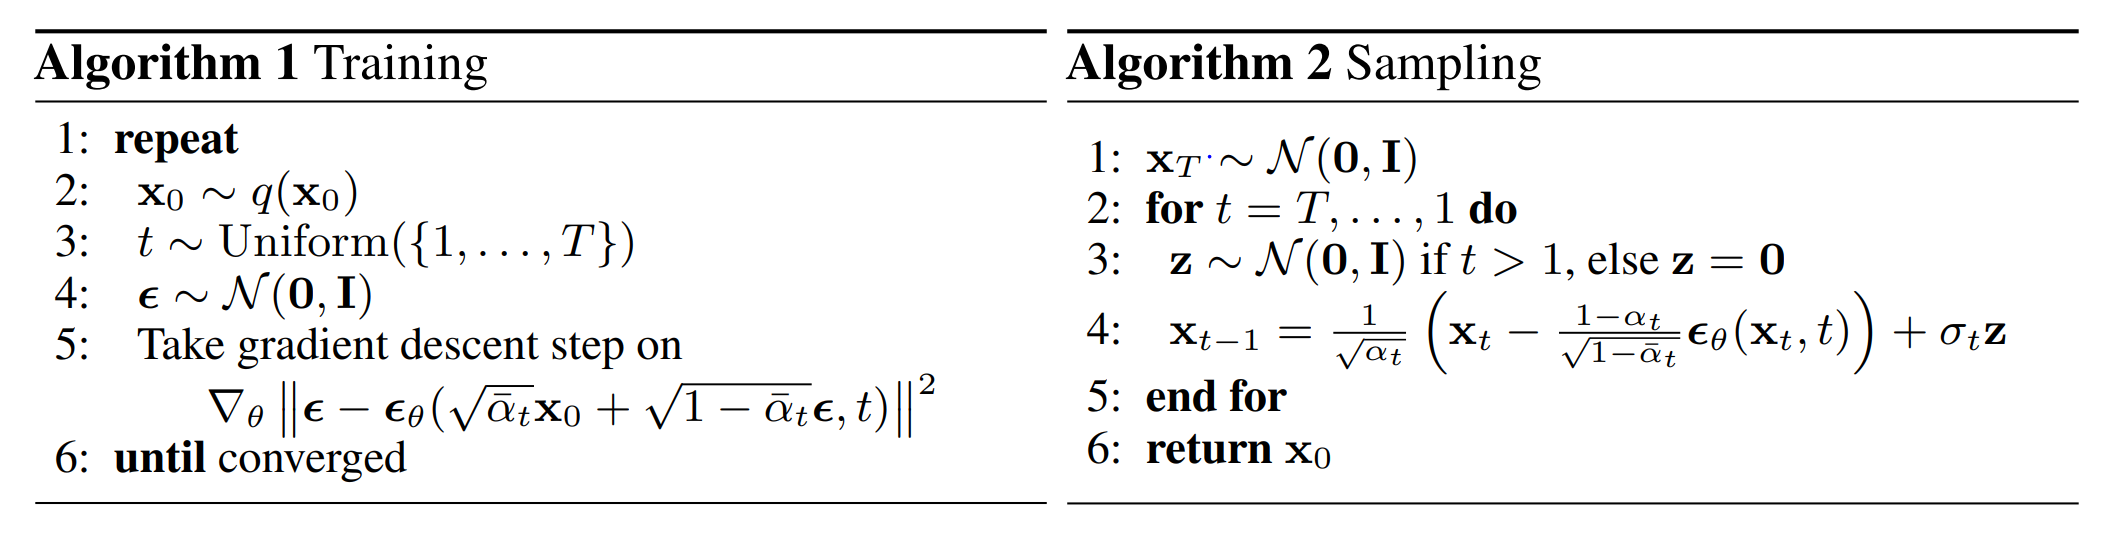

In [32]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ConvResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ConvResNet, self).__init__()
        in_channels , out_channels, groups = args
        self.options = kwargs
        self.residual = self.options.get('residual', False)
        self.mod = self.options.get('mod', 'down')
        if self.mod == 'down':
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.bn1 = nn.GroupNorm(groups, out_channels)
            self.bn2 = nn.GroupNorm(groups, out_channels)
            if self.residual:
                if in_channels != out_channels:
                    self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
                else:
                    self.downsample = None
        if self.mod == 'up':
            self.convt1 = nn.Conv2d(out_channels, in_channels, kernel_size=3, padding=1)
            self.convt2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
            self.bnt1 = nn.GroupNorm(groups, in_channels)
            self.bnt2 = nn.GroupNorm(groups, in_channels)
            if self.residual:
                if in_channels != out_channels:
                    self.upsample = nn.Conv2d(out_channels, in_channels, kernel_size=1, stride=1, bias=False)
                else:
                    self.upsample = None
                
    def forward(self, x):
        
        if self.mod == 'down':
            h = F.gelu(self.bn1(self.conv1(x)))
            h = self.bn2(self.conv2(h))
            if self.residual:
                if self.downsample is not None:
                    x = self.downsample(x)
                h += x
        else:
            h = F.gelu(self.bnt1(self.convt1(x)))
            h = self.bnt2(self.convt2(h))
            if self.residual:
                if self.upsample is not None:
                    x = self.upsample(x)
                h += x
        
        return h
    

class Down(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Down, self).__init__()
        in_channels , out_channels, groups = args
        
        self.convresnet = ConvResNet(in_channels , out_channels, groups,mod='down',residual=True)
        self.downsampling = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2,padding=1)
        self.bn1 = nn.GroupNorm(groups, out_channels)
    def forward(self, x,t):
        batch_size, n_channels, height, width = x.shape
        skip= self.convresnet(x)
        out = skip
        out = self.downsampling(out)
        out = self.bn1(out)
        return skip,out+t.view(batch_size, -1, 1, 1)

class Up(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Up, self).__init__()
        in_channels , out_channels, groups = args
        self.convresnet = ConvResNet(out_channels,in_channels, groups,mod='up',residual=True)
        self.bn2 = nn.GroupNorm(groups, out_channels)
        self.upsampling = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2,padding=1)
        self.bn1 = nn.GroupNorm(groups, out_channels)
    def forward(self, x, skip,t):
        batch_size, n_channels, height, width = x.shape
        x = self.upsampling(x)
        x = self.bn1(x)
        x = torch.concat([x,skip],dim=1)
        x = self.convresnet(x)
        #print(x.shape)
        x = self.bn2(x)
        return x+t.reshape(batch_size, -1, 1, 1)

class Attention(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Attention, self).__init__()
        n_channels, n_heads,d_model = args
        
        self.norm1 = nn.LayerNorm(d_model)
        
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.ReLU(),
            nn.Linear(d_model*2, d_model)
        )
        self.n_heads = n_heads
        
    def forward(self, x):
        batch_size, n_channels, height, width = x.shape
        embeded = x.view(batch_size,n_channels,-1)
        out = self.attn(embeded,embeded,embeded)[0] +embeded 
        out = self.norm1(out)
        out_ = self.ffn(out) + out
        
        return self.norm2(out_).view(batch_size, n_channels, height, width)


class UNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super(UNet, self).__init__()
        in_channel,out_channel= args
        self.time_embedding = nn.Embedding(1000, 100)
        
        positions = torch.arange(1000).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, 100, 2) * -(math.log(10000.0) / 100))
        embeddings = torch.zeros(1000, 100)
        embeddings[:, 0::2] = torch.sin(positions * div_term)
        embeddings[:, 1::2] = torch.cos(positions * div_term)

        self.time_embedding.weight.data = embeddings
        self.time_embedding.requires_grad_(False)
        
        self.convnet_down = ConvResNet(in_channel,out_channel,8,mod='down',residual=False)
        
        self.down_1 = Down(out_channel,2*out_channel,8)
        self.time_1 =  nn.Sequential(
            nn.Linear(100, 2*out_channel),
            nn.SiLU(),
            nn.Linear(2*out_channel, 2*out_channel)
        )
        self.att_1 = Attention(2*out_channel,1,16*16 )
        self.down_2 = Down(2*out_channel,4*out_channel,8)
        self.time_2 =  nn.Sequential(
            nn.Linear(100, 4*out_channel),
            nn.SiLU(),
            nn.Linear(4*out_channel, 4*out_channel)
        )
        self.att_2 = Attention(4*out_channel,1,8*8 )
        self.down_3 = Down(4*out_channel,8*out_channel,8)
        self.time_3 =  nn.Sequential(
            nn.Linear(100, 8*out_channel),
            nn.SiLU(),
            nn.Linear(8*out_channel, 8*out_channel)
        )
        self.att_3 = Attention(4*out_channel,1,4*4 )
        self.down_4 = Down(8*out_channel,16*out_channel,8)
        self.time_4 =  nn.Sequential(
            nn.Linear(100, 16*out_channel),
            nn.SiLU(),
            nn.Linear(16*out_channel, 16*out_channel)
        )
        self.bottleneck = ConvResNet(16*out_channel,32*out_channel,8,mod='down',residual=True)
        
        self.up_1 = Up(32*out_channel,16*out_channel,8)
        self.time_5 =  nn.Sequential(
            nn.Linear(100, 8*out_channel),
            nn.SiLU(),
            nn.Linear(8*out_channel, 16*out_channel)
        )
        self.up_2 = Up(16*out_channel,8*out_channel,8)
        self.time_6 =  nn.Sequential(
            nn.Linear(100, 8*out_channel),
            nn.SiLU(),
            nn.Linear(8*out_channel, 8*out_channel)
        )
        self.att_4 = Attention(4*out_channel,1,8*8 )
        self.up_3 = Up(8*out_channel,4*out_channel,8)
        self.time_7 =  nn.Sequential(
            nn.Linear(100, 4*out_channel),
            nn.SiLU(),
            nn.Linear(4*out_channel, 4*out_channel)
        )
        self.att_5 = Attention(4*out_channel,1,16*16 )
        self.up_4 = Up(4*out_channel,2*out_channel,8)
        self.time_8 =  nn.Sequential(
            nn.Linear(100, 2*out_channel),
            nn.SiLU(),
            nn.Linear(2*out_channel, 2*out_channel)
        )
        self.att_6 = Attention(4*out_channel,1,32*32 )
        self.convnet_up = ConvResNet(2*out_channel,1,1,mod='down',residual=True)
                
    def forward(self, x,t):
        t_embedded = self.time_embedding(t)
       
        out  = self.convnet_down(x)
        skip_1,out = self.down_1(out,self.time_1(t_embedded))
        out = self.att_1(out)
        t_embedded_1 = self.time_embedding(t)
        skip_2,out = self.down_2(out,self.time_2(t_embedded))
        out = self.att_2(out)
        skip_3,out = self.down_3(out,self.time_3(t_embedded))
        out = self.att_3(out)
        skip_4,out = self.down_4(out,self.time_4(t_embedded))
        
        out = self.bottleneck(out)
        out = self.up_1(out,skip_4,self.time_5(t_embedded))
        out = self.up_2(out,skip_3,self.time_6(t_embedded))
        out = self.att_4(out)
        out = self.up_3(out,skip_2,self.time_7(t_embedded))
        out = self.att_5(out)
        out = self.up_4(out,skip_1,self.time_8(t_embedded))
        out = self.att_6(out)
        out  = self.convnet_up(out)
        
        return out


In [33]:
class DDPMManager():
    def __init__(self):

        self.T = 1000
        self.beta_start = 1e-4 # \beta_t is the sqrt(\sigma_t) from the pseudocode.
        self.beta_end = 0.02


        self.unet = UNet(1,8).to(DEVICE)
        #self.unet = TinyUNet(input_channels=1, output_channels=1, size=32).to(DEVICE)
        self.optim = optim.Adam(self.unet.parameters(), lr=LR)
        #self.betas = torch.tensor([self.beta_start + (self.beta_end - self.beta_start) * (1 + math.cos(math.pi * t / self.T)) / 2 for t in range(self.T)]).to(DEVICE)
        self.betas = torch.linspace(self.beta_start,self.beta_end,self.T, dtype=torch.float32).to(DEVICE)
        #t = torch.linspace(0, self.T, self.T+1, dtype=torch.float32) / self.T
        #t1 = torch.cos((t + 0.008) / (1 + 0.008) * math.pi * 0.5) ** 2
        #t1 = t1 / t1[0]
        #self.betas = torch.clip(1 - (t1[1:] / t1[:-1]), 0, 0.99).to(DEVICE)#cosine schedule https://openreview.net/forum?id=-NEXDKk8gZ
        self.alpha = 1.0 - self.betas
        self.alpha_bar =torch.cumprod(self.alpha,dim=0).to(DEVICE)
        self.n1 = torch.sqrt(self.alpha_bar)
        self.n2 = torch.sqrt(1 - self.alpha_bar)
        
    def train(self, dataloader, **kwargs):

        history = dict(loss=[])
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)

                #for i in range(len(batch_x)): memory error
                #batch_ = batch_x[0] 
                timesteps = torch.randint(0, 1000, (BATCH_SIZE,), dtype=torch.long).to(DEVICE)
                #print(timesteps.shape)
                noise = torch.randn_like(batch_x).to(DEVICE)
                #print(noise.shape)
                #print('s1s2',self.n1[timesteps].reshape(-1, 1, 1, 1).shape, self.n2[timesteps].reshape(-1, 1, 1, 1).shape)
                noise_ = self.n1[timesteps].reshape(-1, 1, 1, 1) *batch_x + self.n2[timesteps].reshape(-1, 1, 1, 1) *noise
                #print(noise_.shape)
                noise_pred = self.unet(noise_,timesteps)
                
                loss = F.mse_loss(noise_pred, noise)
                #print(noise_pred.shape, noise.shape)
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, EPOCHS, mean_loss)
            )

            self.sample(8, plot=True)

            history['loss'].append(mean_loss)

        return history
    
    def sample(self, n, plot=True):


        with torch.no_grad():
            x = torch.randn(n, 1, 32, 32).to(DEVICE)
            timesteps = list(range(self.T))[::-1] 
            xs = [ ]
            for i, t in enumerate(tqdm(timesteps)):
                time_tensor = (torch.ones(n, 1) * t).long().to(DEVICE)
                noise = self.unet(x, time_tensor)
                t_ = time_tensor[0]
                coef_epsilon = (1 - self.alpha) / self.n2
                #print(self.alpha.shape,self.n2.shape )
                coef_eps_t = coef_epsilon[t_ ].reshape(-1, 1, 1, 1)
                coef_first = 1 / self.alpha.pow(0.5)
                coef_first_t = coef_first[t_ ].reshape(-1, 1, 1, 1)
                #print(t_.shape,coef_epsilon.shape, coef_first.shape)
                #print('coef_first', coef_first_t.shape,'x',x.shape,'coef_eps_t', coef_eps_t.shape,'noise',noise.shape )
                pred_prev_sample = coef_first_t * (x - coef_eps_t * noise)

                variance = 0
                if t_ > 0:
                  noise_ = torch.randn_like(noise).to(DEVICE)
                  variance = (self.betas[t_ ].pow(0.5)) * noise_

                x = pred_prev_sample + variance

            for i in range(n):
                xs.append(x[i])           
            if plot:
                plot_images(xs)
            return x

In [ ]:
ddpm = DDPMManager() # You can pass your arguments to the call.
ddpm_history = ddpm.train(dataloader)

In [24]:
def show_images(images, title=""):


    num_images = len(images)
    num_rows = 5
    num_cols = 5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    fig.suptitle(title, fontsize=30)
    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(images[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
        axes[row, col].axis("off")
    # Show the figure
    plt.show()

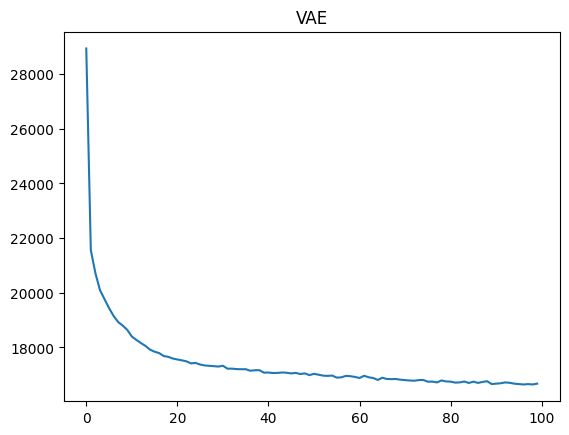

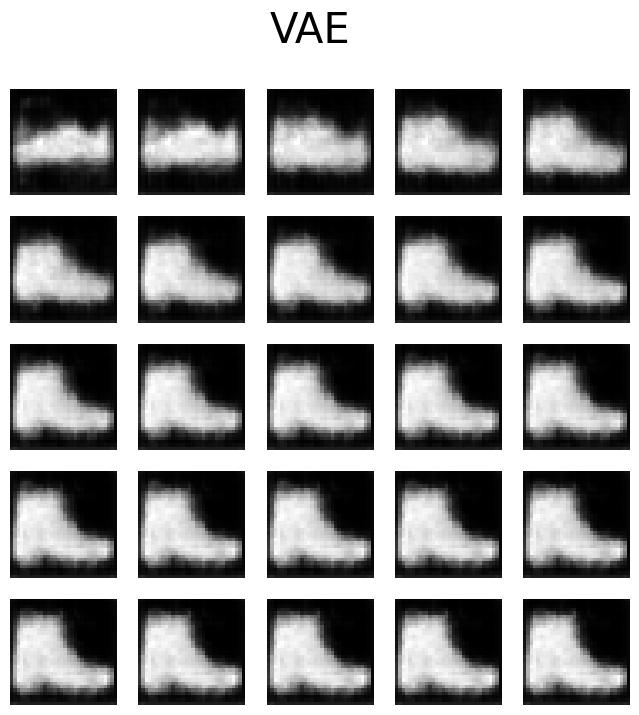

In [27]:
plt.plot(vae_history['loss'],)
plt.title('VAE')
plt.show()

show_images(vae.sample(25,False), 'VAE')

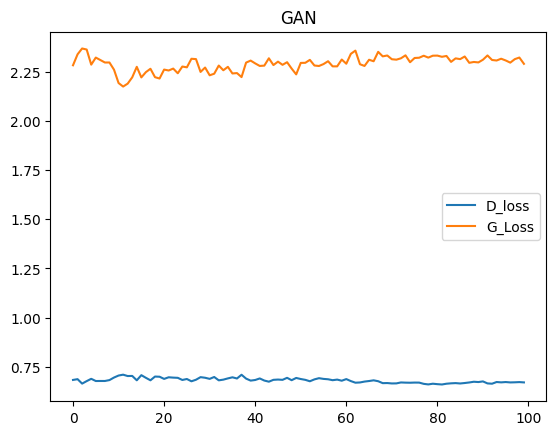

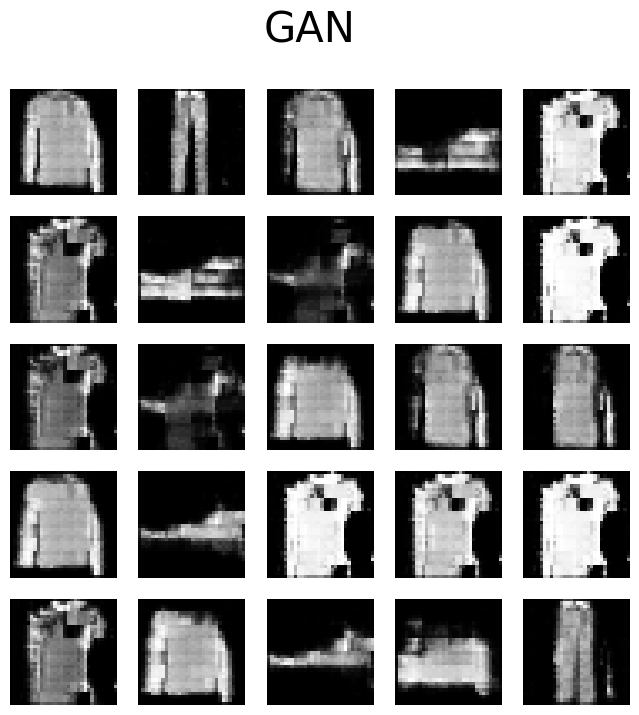

In [31]:
plt.plot(gan_history['d_loss'], label="D_loss")
plt.plot(gan_history['g_loss'],label="G_Loss")

plt.title('GAN')
plt.legend()
plt.show()
show_images( gan.sample(25,False), 'GAN')

  0%|          | 0/1000 [00:00<?, ?it/s]

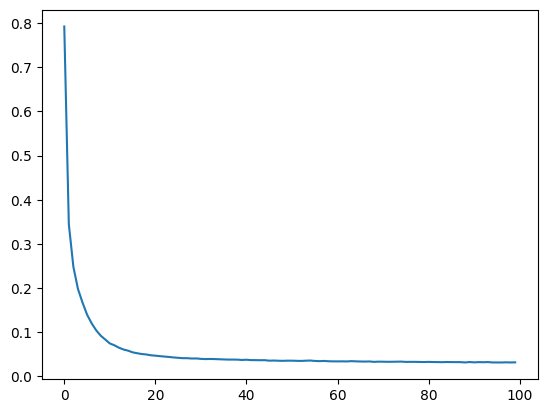

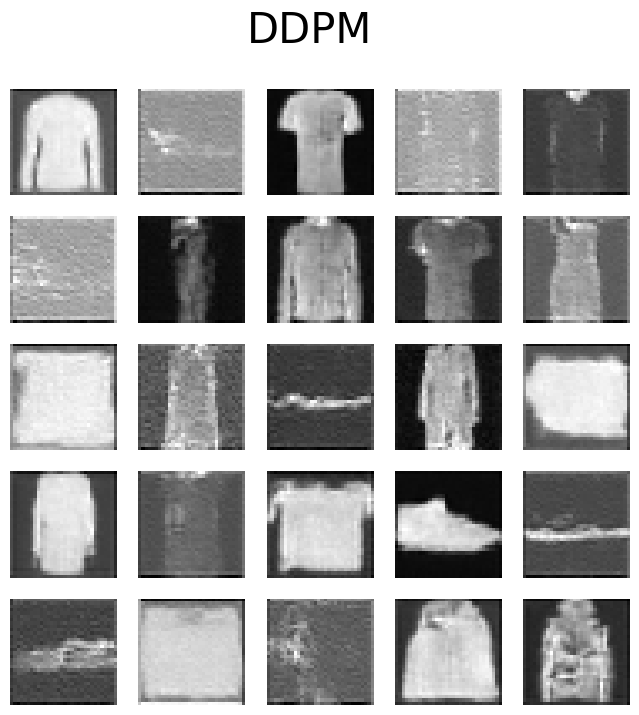

In [35]:
plt.plot(ddpm_history['loss'], label="DDPM")
show_images( ddpm.sample(25,False), 'DDPM')